# Trabalho Final - INF 493

> Alunos: Cleber Luiz Oliveira Junior, Vinicius Kuster Lodi


## Imports iniciais e upload da tabela

In [ ]:
# Imports iniciais:

import pandas as pd
import matplotlib as mtplt
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [ ]:
%pip install catboost xgboost

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [ ]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [ ]:
base = pd.read_excel('basePreProcessamento2500Instancias.xlsx')

In [ ]:
base.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
UF_NOTIF,2500.0,33.650800,5.758934,11.0,31.0,34.0,34.0,53.0
IDADE,2500.0,39.190800,19.118133,0.0,24.0,39.0,53.0,95.0
SEXO,2500.0,0.682800,0.465479,0.0,0.0,1.0,1.0,1.0
VACINA_FA,2500.0,1.620000,0.613637,1.0,1.0,2.0,2.0,3.0
SINT_HEMORRAGICO,2500.0,1.971600,0.578037,1.0,2.0,2.0,2.0,3.0
DISTUR_RENAL,2500.0,1.960800,0.599506,1.0,2.0,2.0,2.0,3.0
SINAL_FAGET,2500.0,2.057200,0.548861,1.0,2.0,2.0,2.0,3.0
DOR_ABDOMINAL,2500.0,1.936800,0.843024,1.0,1.0,2.0,3.0,3.0
RESULT_IGM,2500.0,2.114000,0.636527,1.0,2.0,2.0,3.0,3.0
RESULT_PCR,2500.0,2.200000,0.701567,1.0,2.0,2.0,3.0,3.0


# Análise Gráfica

## Boxplots

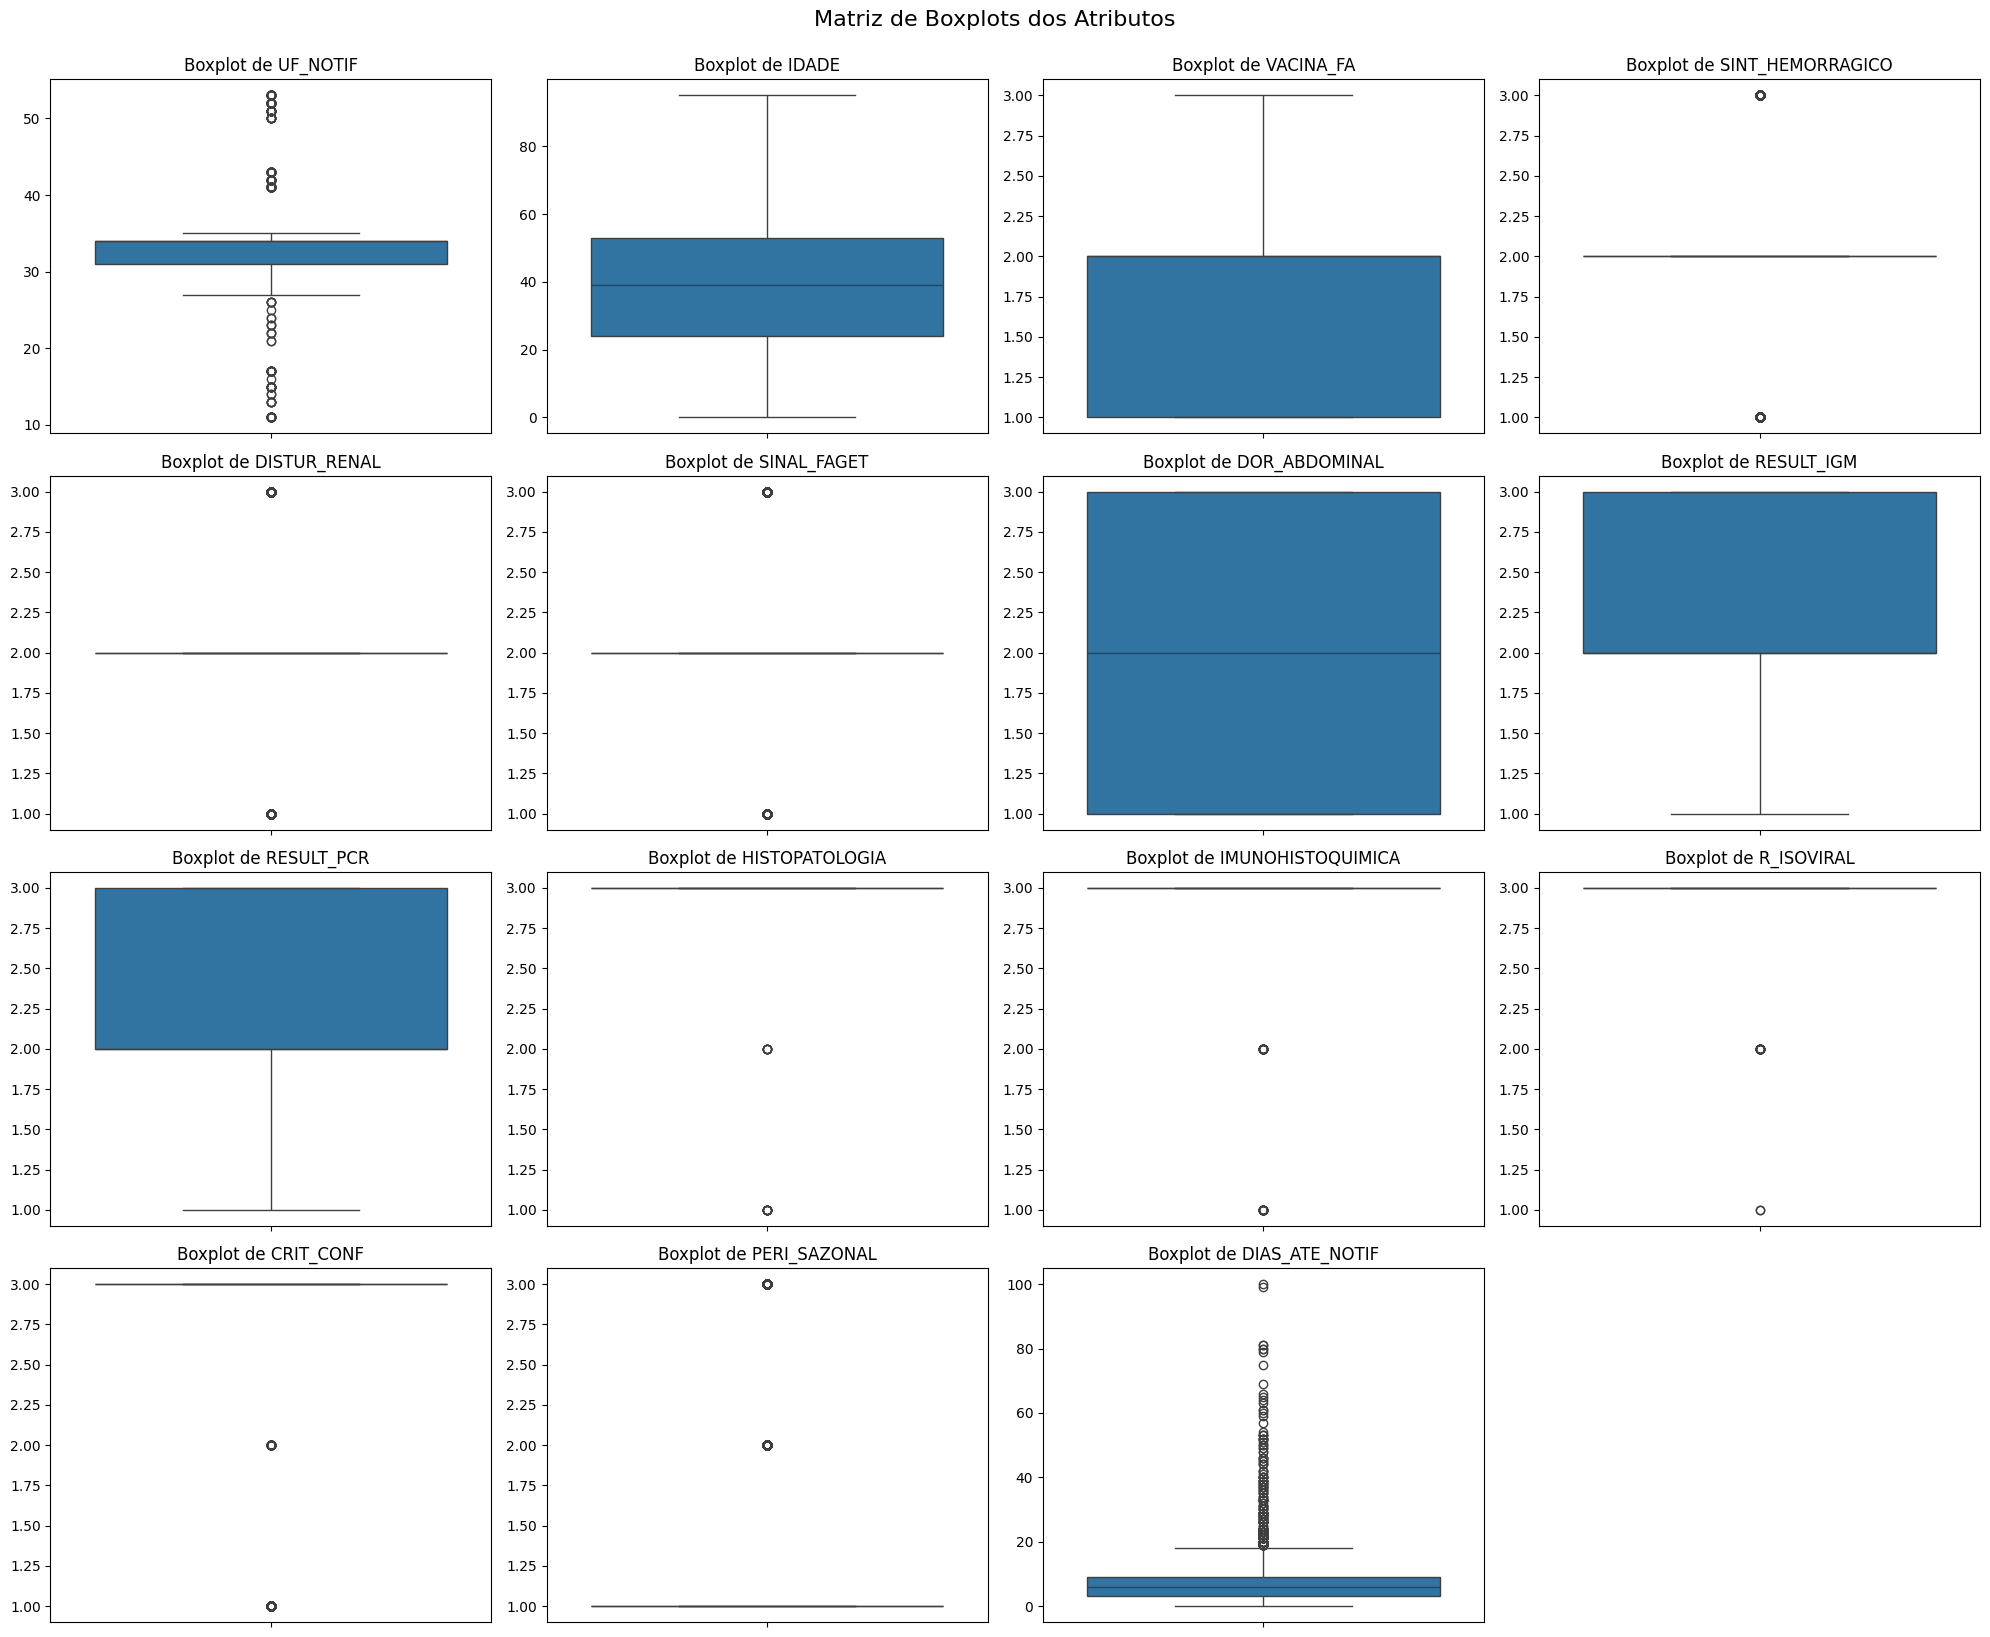

In [ ]:
# Identificar colunas numéricas/ordinais para boxplots, excluindo binárias
excluded_cols = ['SEXO', 'OBITO', 'INTERNACAO']
numerical_cols_for_boxplot = [col for col in base.columns if col not in excluded_cols]

if not numerical_cols_for_boxplot:
    print("Nenhuma coluna numérica adequada encontrada para gerar boxplots após exclusão de binárias.")
else:
    # Definir o número de colunas para o grid de plots
    n_cols = 4  # Ajuste conforme preferência
    n_rows = (len(numerical_cols_for_boxplot) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() # Achatar o array de eixos para facilitar a iteração

    for i, col in enumerate(numerical_cols_for_boxplot):
        sns.boxplot(y=base[col], ax=axes[i])
        axes[i].set_title(f'Boxplot de {col}')
        axes[i].set_ylabel('') # Remover rótulo do eixo y para evitar sobreposição

    # Remover eixos vazios, se houver
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Matriz de Boxplots dos Atributos', y=1.02, fontsize=16)
    plt.show()

Conclusão: há outliers, mas eles são totalmente normais no contexto do problema e são importantes no treinamento da base, só precisa haver maior cuidado com a normalização

## Distribuição de variaveis

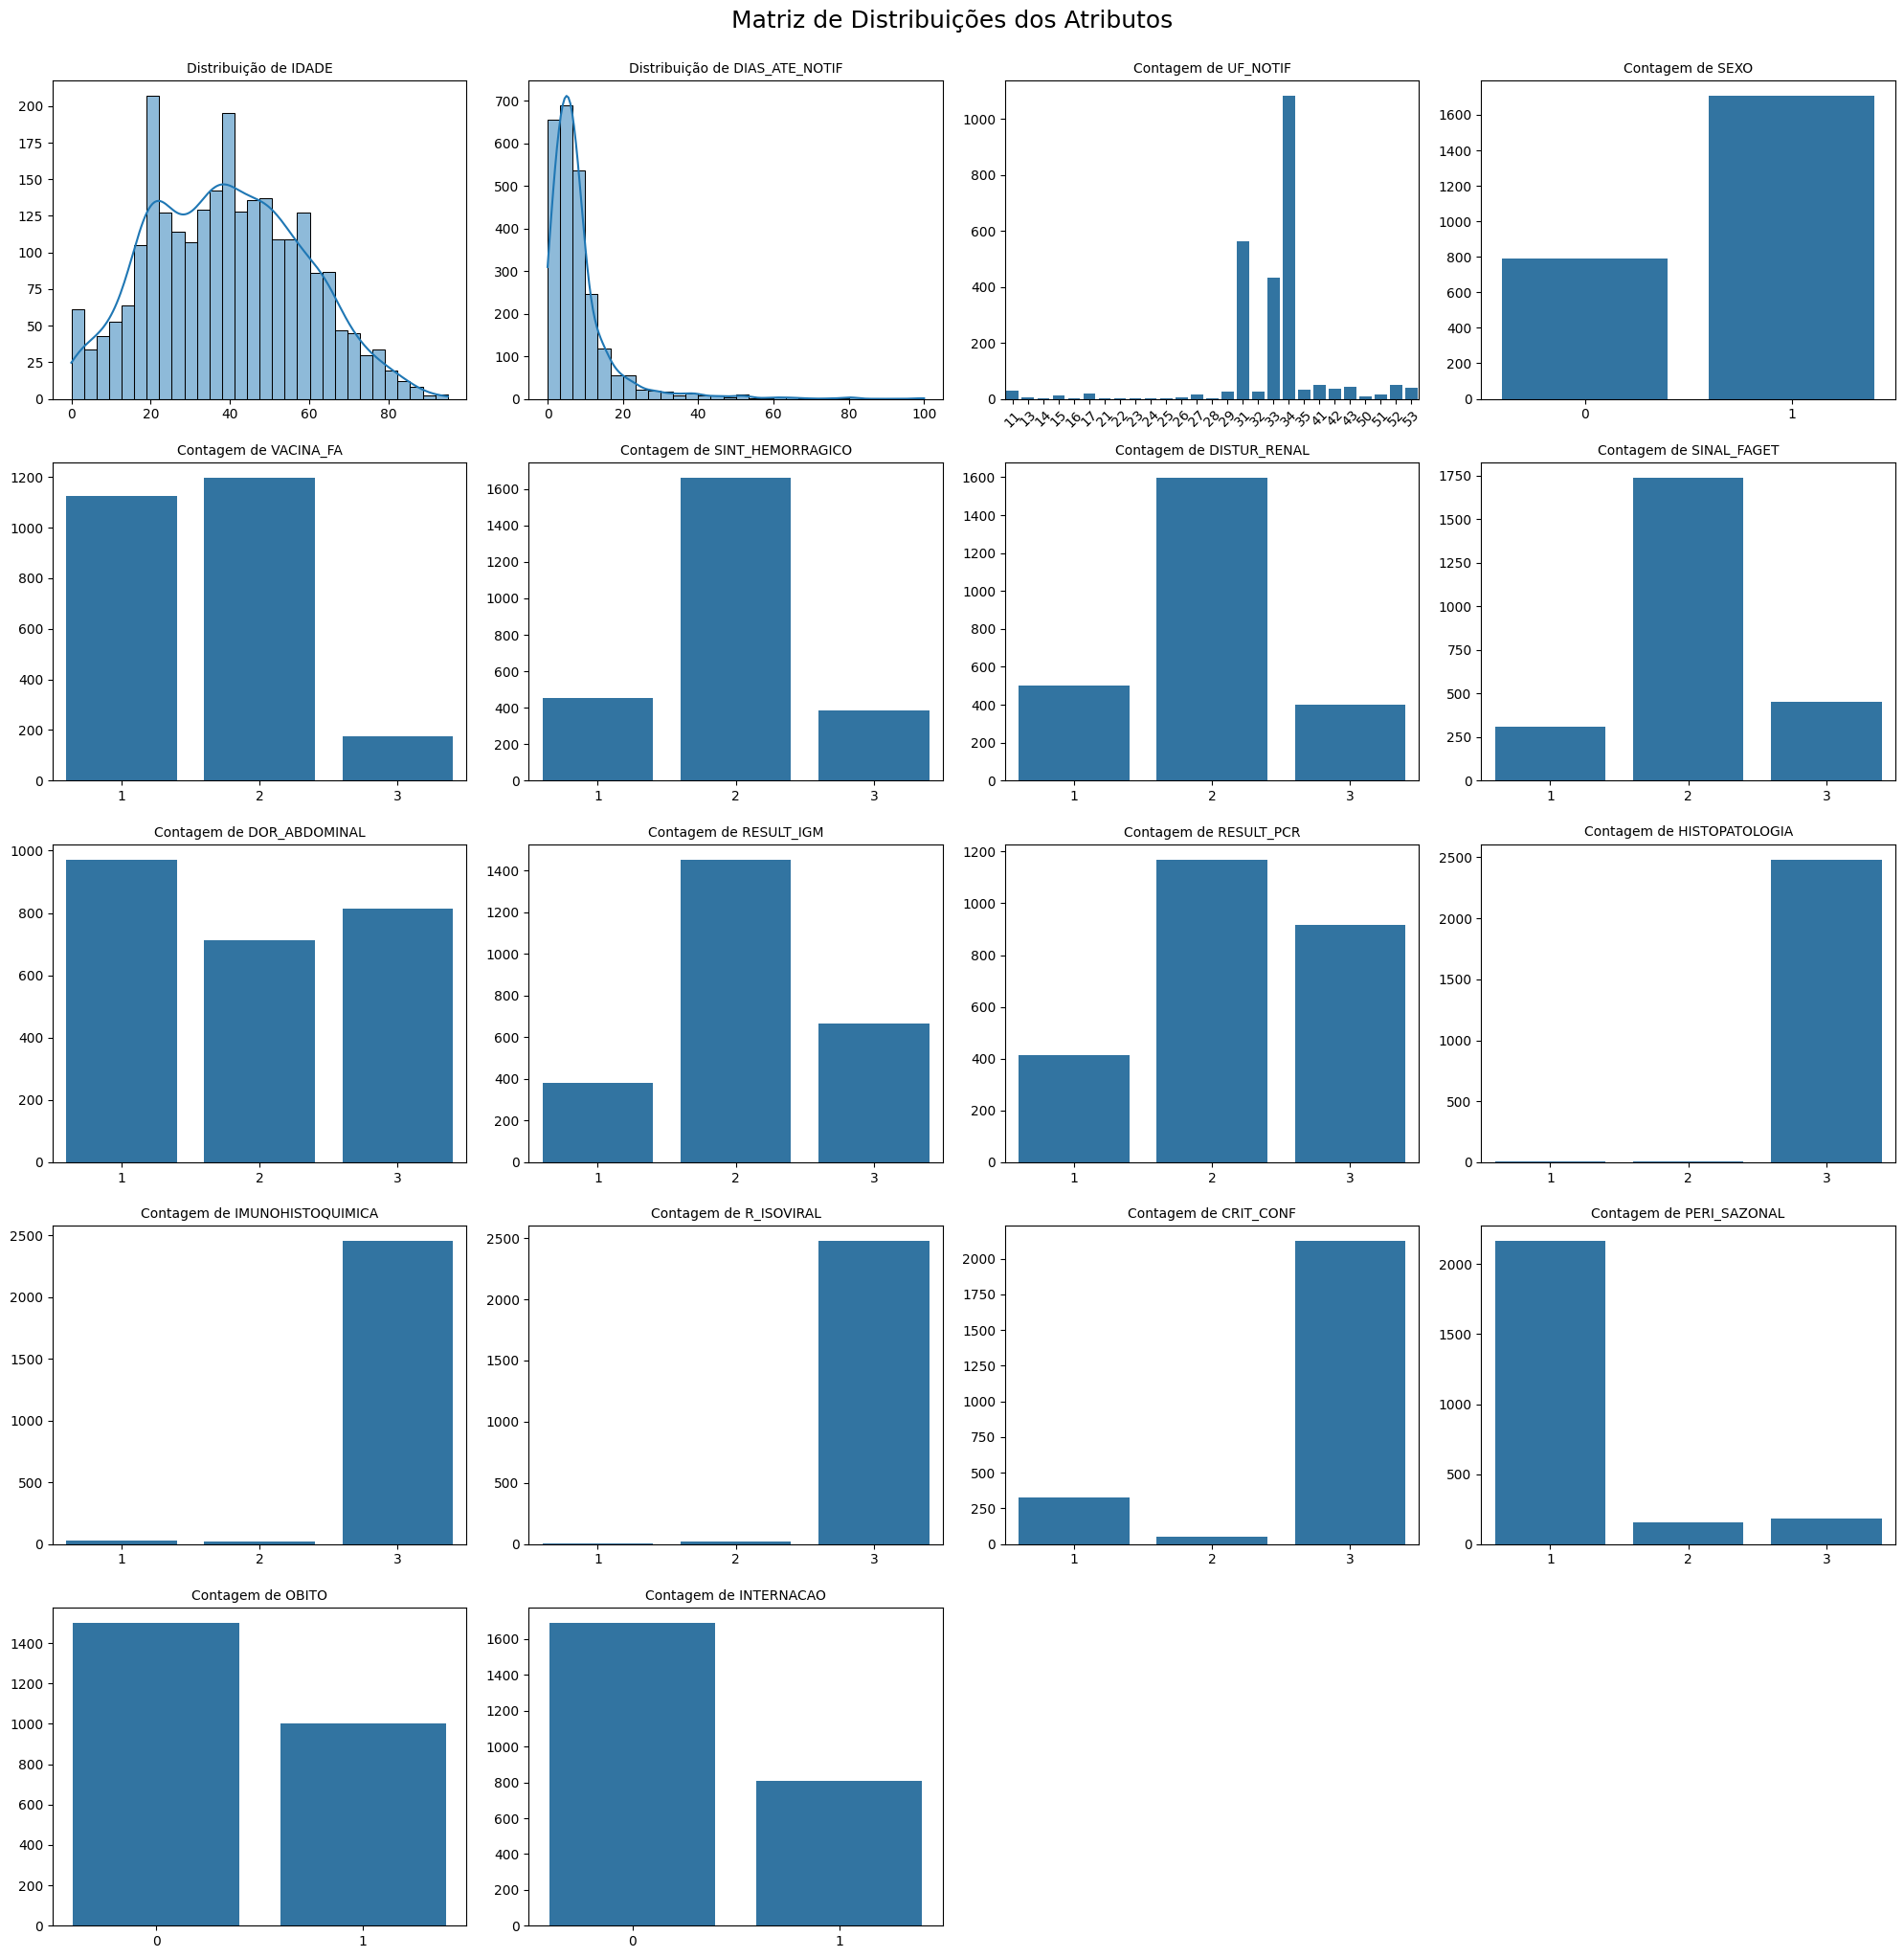

In [ ]:
# Definir as colunas para cada tipo de plot
continuous_numerical_cols = ['IDADE', 'DIAS_ATE_NOTIF']
discrete_categorical_cols = [col for col in base.columns if col not in continuous_numerical_cols]

all_columns_to_plot = continuous_numerical_cols + discrete_categorical_cols

if not all_columns_to_plot:
    print("Nenhuma coluna encontrada no DataFrame para gerar distribuições.")
else:
    n_cols = 4  # Número de colunas no grid de plots
    n_rows = (len(all_columns_to_plot) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() # Achatar o array de eixos para facilitar a iteração

    for i, col in enumerate(all_columns_to_plot):
        ax = axes[i]
        if col in continuous_numerical_cols:
            # Para colunas numéricas contínuas, usar histplot com KDE
            sns.histplot(data=base, x=col, kde=True, ax=ax, bins=30)
            ax.set_title(f'Distribuição de {col}', fontsize=10)
        else:
            # Para colunas discretas/categóricas, usar countplot
            # Garantir que a coluna exista e não seja totalmente NA
            if col in base.columns and not base[col].dropna().empty:
                # Ordenar os valores únicos para o eixo x em ordem crescente
                ordered_values = sorted(base[col].dropna().unique())
                sns.countplot(data=base, x=col, ax=ax, order=ordered_values)
                ax.set_title(f'Contagem de {col}', fontsize=10)
                # Rotacionar labels se houver muitas categorias ou nomes longos
                if base[col].nunique() > 5 or base[col].astype(str).apply(len).max() > 5:
                    ax.tick_params(axis='x', rotation=45)
            else:
                ax.text(0.5, 0.5, 'Dados Ausentes ou Vazios', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_title(f'{col}', fontsize=10)

        ax.set_xlabel('') # Remover rótulo do eixo x para clareza no grid
        ax.set_ylabel('') # Remover rótulo do eixo y para clareza no grid

    # Remover eixos vazios, se houver
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Matriz de Distribuições dos Atributos', y=1.02, fontsize=18)
    plt.show()

Conclusão: as distribuições de valores continuos são normais, e quando exponenciais, fazem sentido com a definição da variável

## Matriz de correlação

Pares de atributos com correlação absoluta >= 15.0% (diagonal principal excluída):


SINT_HEMORRAGICO  DISTUR_RENAL        0.620346
DISTUR_RENAL      SINT_HEMORRAGICO    0.620346
                  SINAL_FAGET         0.558937
SINAL_FAGET       DISTUR_RENAL        0.558937
                  SINT_HEMORRAGICO    0.528558
                                        ...   
CRIT_CONF         RESULT_PCR         -0.378321
                  PERI_SAZONAL       -0.384862
PERI_SAZONAL      CRIT_CONF          -0.384862
CRIT_CONF         INTERNACAO         -0.442861
INTERNACAO        CRIT_CONF          -0.442861
Length: 68, dtype: float64

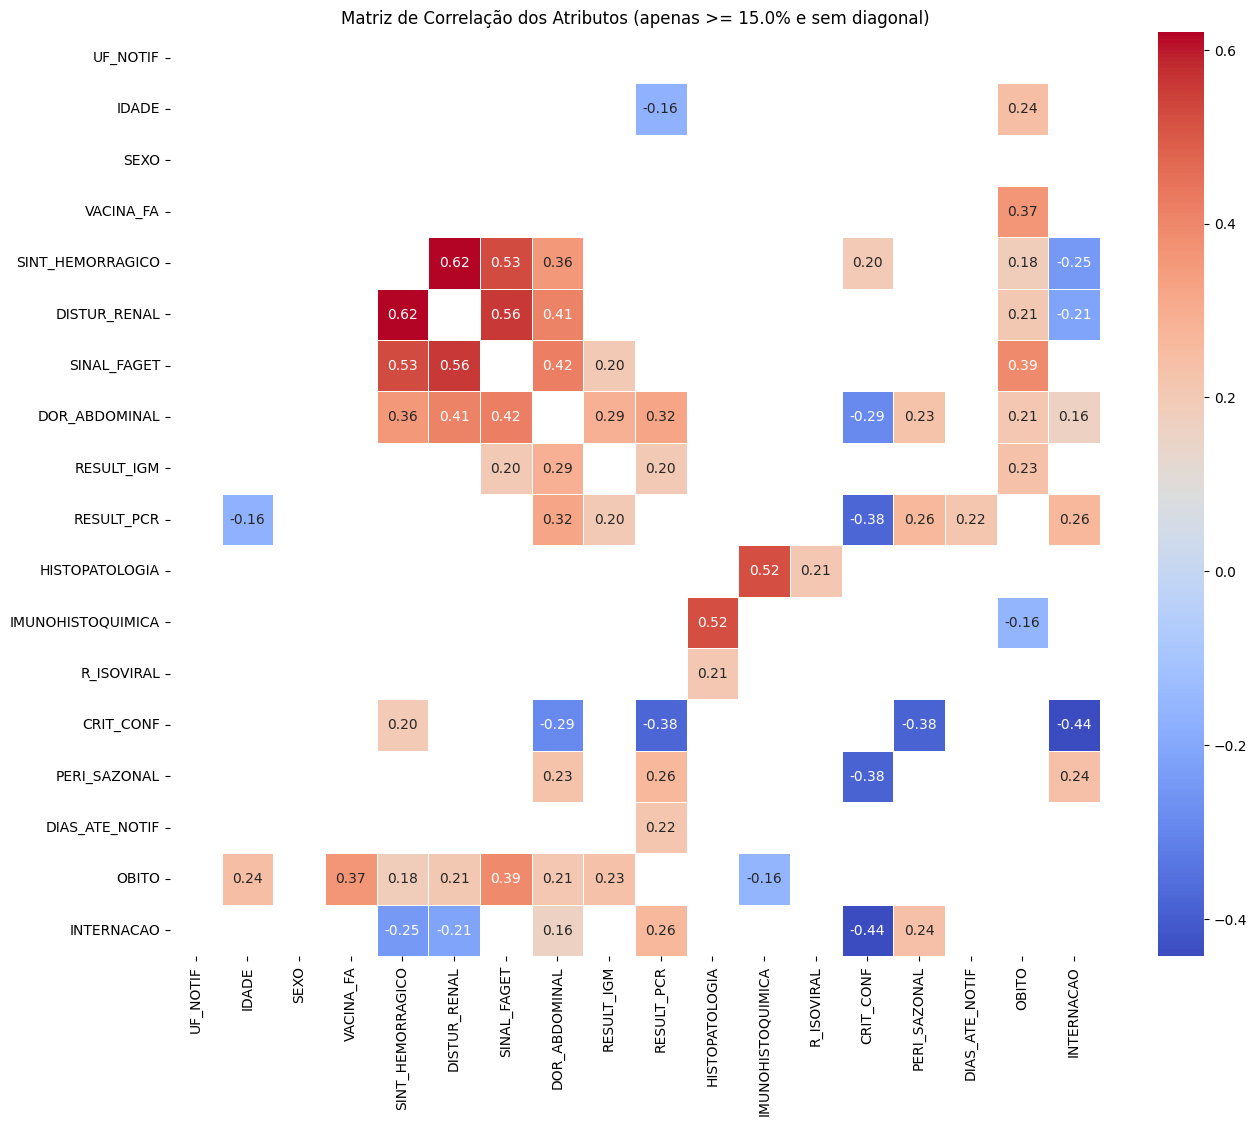

In [ ]:
# Calcular a matriz de correlação
correlation_matrix = base.corr(numeric_only=True)

# Definir o novo filtro de correlação
filter_threshold = 0.15

# Filtrar correlações >= 15% (em valor absoluto), excluindo a diagonal principal
high_correlation_mask = (correlation_matrix.abs() >= filter_threshold) & (correlation_matrix.abs() < 1.0)

# Aplicar a máscara para mostrar apenas as correlações desejadas
highly_correlated_pairs = correlation_matrix[high_correlation_mask].stack().sort_values(ascending=False)

if not highly_correlated_pairs.empty:
    print(f"Pares de atributos com correlação absoluta >= {filter_threshold*100}% (diagonal principal excluída):")
    display(highly_correlated_pairs)
else:
    print(f"Nenhum par de atributos encontrado com correlação absoluta >= {filter_threshold*100}% (diagonal principal excluída).")

# Visualizar a matriz completa com um heatmap, mostrando apenas correlações acima do threshold e excluindo a diagonal
plt.figure(figsize=(15, 12))

# Criar uma máscara para esconder os valores abaixo do threshold OU na diagonal principal
mask = (correlation_matrix.abs() < filter_threshold) | (correlation_matrix.abs() == 1.0)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title(f'Matriz de Correlação dos Atributos (apenas >= {filter_threshold*100}% e sem diagonal)')
plt.show()

In [ ]:
# Selecionar apenas as colunas numéricas para o cálculo
numerical_cols = base.select_dtypes(include=np.number).columns

# Calcular a variância
variance_values = base[numerical_cols].var()

print("Variância de cada atributo:")
display(variance_values.dropna().sort_values(ascending=False))

Variância de cada atributo:


,0
IDADE,365.502997
DIAS_ATE_NOTIF,90.297350
UF_NOTIF,33.165325
DOR_ABDOMINAL,0.710690
RESULT_PCR,0.492197
CRIT_CONF,0.466037
RESULT_IGM,0.405166
VACINA_FA,0.376551
DISTUR_RENAL,0.359407
SINT_HEMORRAGICO,0.334127


Analisando a correlação e a variância, foram removidas as colunas REG_NOTIF, HOSPITALIZACAO e AUTOCTONE, pois são muito correlacionadas com UF_NOTIF, INTERNACAO e CRIT_CONF, repectivamente, e possuem a menor variancia

In [ ]:
# Remover de colunas com maior correlação e menor variancia
base = base.drop(['REG_NOTIF', 'HOSPITALIZACAO', 'AUTOCTONE'], axis=1, errors='ignore')
print("Colunas dropadas.")


Colunas dropadas.


In [ ]:
print(base.columns.tolist())

['UF_NOTIF', 'IDADE', 'SEXO', 'VACINA_FA', 'SINT_HEMORRAGICO', 'DISTUR_RENAL', 'SINAL_FAGET', 'DOR_ABDOMINAL', 'RESULT_IGM', 'RESULT_PCR', 'HISTOPATOLOGIA', 'IMUNOHISTOQUIMICA', 'R_ISOVIRAL', 'CRIT_CONF', 'PERI_SAZONAL', 'DIAS_ATE_NOTIF', 'OBITO', 'INTERNACAO']


# Normalização das variaveis

> Objetiva deixa-las em uma mesma escala e diminuir suas variações

Foi escolhido o RobustScaler pois trata melhor os outliers

In [ ]:
# Identificar todas as colunas numéricas para escalonamento
numerical_cols_to_scale = base.select_dtypes(include=np.number).columns.tolist()

# Inicializar o RobustScaler
r_scaler = RobustScaler()

# Aplicar o RobustScaler nas colunas numéricas selecionadas
base[numerical_cols_to_scale] = r_scaler.fit_transform(base[numerical_cols_to_scale])

print("RobustScaler aplicado com sucesso nas colunas:", numerical_cols_to_scale)
display(base.head())

RobustScaler aplicado com sucesso nas colunas: ['UF_NOTIF', 'IDADE', 'SEXO', 'VACINA_FA', 'SINT_HEMORRAGICO', 'DISTUR_RENAL', 'SINAL_FAGET', 'DOR_ABDOMINAL', 'RESULT_IGM', 'RESULT_PCR', 'HISTOPATOLOGIA', 'IMUNOHISTOQUIMICA', 'R_ISOVIRAL', 'CRIT_CONF', 'PERI_SAZONAL', 'DIAS_ATE_NOTIF', 'OBITO', 'INTERNACAO']


,UF_NOTIF,IDADE,SEXO,VACINA_FA,SINT_HEMORRAGICO,DISTUR_RENAL,SINAL_FAGET,DOR_ABDOMINAL,RESULT_IGM,RESULT_PCR,HISTOPATOLOGIA,IMUNOHISTOQUIMICA,R_ISOVIRAL,CRIT_CONF,PERI_SAZONAL,DIAS_ATE_NOTIF,OBITO,INTERNACAO
0,0.333333,-0.206897,-1.0,0.0,0.0,0.0,0.0,-0.5,0.0,1.0,0.0,0.0,0.0,-2.0,0.0,3.333333,1.0,1.0
1,6.000000,0.862069,0.0,-1.0,0.0,0.0,0.0,-0.5,0.0,1.0,0.0,0.0,0.0,-2.0,0.0,-0.166667,1.0,1.0
2,0.333333,0.275862,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.0,0.0,0.166667,1.0,1.0
3,6.000000,-0.586207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.0,2.0,-0.833333,1.0,1.0
4,0.333333,0.241379,0.0,-1.0,0.0,0.0,0.0,-0.5,0.0,1.0,0.0,0.0,0.0,-2.0,2.0,0.500000,1.0,1.0


In [ ]:
base.describe().T

,count,mean,std,min,25%,50%,75%,max
UF_NOTIF,2500.0,-0.116400,1.919645,-7.666667,-1.000000,0.0,0.000000,6.333333
IDADE,2500.0,0.006579,0.659246,-1.344828,-0.517241,0.0,0.482759,1.931034
SEXO,2500.0,-0.317200,0.465479,-1.000000,-1.000000,0.0,0.000000,0.000000
VACINA_FA,2500.0,-0.380000,0.613637,-1.000000,-1.000000,0.0,0.000000,1.000000
SINT_HEMORRAGICO,2500.0,-0.028400,0.578037,-1.000000,0.000000,0.0,0.000000,1.000000
DISTUR_RENAL,2500.0,-0.039200,0.599506,-1.000000,0.000000,0.0,0.000000,1.000000
SINAL_FAGET,2500.0,0.057200,0.548861,-1.000000,0.000000,0.0,0.000000,1.000000
DOR_ABDOMINAL,2500.0,-0.031600,0.421512,-0.500000,-0.500000,0.0,0.500000,0.500000
RESULT_IGM,2500.0,0.114000,0.636527,-1.000000,0.000000,0.0,1.000000,1.000000
RESULT_PCR,2500.0,0.200000,0.701567,-1.000000,0.000000,0.0,1.000000,1.000000


In [ ]:
# Selecionar apenas as colunas numéricas para o cálculo
numerical_cols = base.select_dtypes(include=np.number).columns

# Calcular a variância
variance_values = base[numerical_cols].var()

print("Variância de cada atributo:")
display(variance_values.dropna().sort_values(ascending=False))

Variância de cada atributo:


,0
UF_NOTIF,3.685036
DIAS_ATE_NOTIF,2.508260
RESULT_PCR,0.492197
CRIT_CONF,0.466037
IDADE,0.434605
RESULT_IGM,0.405166
VACINA_FA,0.376551
DISTUR_RENAL,0.359407
SINT_HEMORRAGICO,0.334127
PERI_SAZONAL,0.309523


#AJUSTE FINAL

In [ ]:
base.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
UF_NOTIF,2500.0,-0.116400,1.919645,-7.666667,-1.000000,0.0,0.000000,6.333333
IDADE,2500.0,0.006579,0.659246,-1.344828,-0.517241,0.0,0.482759,1.931034
SEXO,2500.0,-0.317200,0.465479,-1.000000,-1.000000,0.0,0.000000,0.000000
VACINA_FA,2500.0,-0.380000,0.613637,-1.000000,-1.000000,0.0,0.000000,1.000000
SINT_HEMORRAGICO,2500.0,-0.028400,0.578037,-1.000000,0.000000,0.0,0.000000,1.000000
DISTUR_RENAL,2500.0,-0.039200,0.599506,-1.000000,0.000000,0.0,0.000000,1.000000
SINAL_FAGET,2500.0,0.057200,0.548861,-1.000000,0.000000,0.0,0.000000,1.000000
DOR_ABDOMINAL,2500.0,-0.031600,0.421512,-0.500000,-0.500000,0.0,0.500000,0.500000
RESULT_IGM,2500.0,0.114000,0.636527,-1.000000,0.000000,0.0,1.000000,1.000000
RESULT_PCR,2500.0,0.200000,0.701567,-1.000000,0.000000,0.0,1.000000,1.000000


Reajuste da coluna DIAS_ATE_NOTIF que ainda possuia valores ausentes

In [ ]:
print(f"Número de linhas antes da remoção: {base.shape[0]}")

# Remover linhas onde 'DIAS_ATE_NOTIF' é nulo
base.dropna(subset=['DIAS_ATE_NOTIF'], inplace=True)

print(f"Número de linhas após a remoção: {base.shape[0]}")
print("Linhas com valores nulos na coluna 'DIAS_ATE_NOTIF' foram removidas com sucesso.")

Número de linhas antes da remoção: 2500
Número de linhas após a remoção: 2486
Linhas com valores nulos na coluna 'DIAS_ATE_NOTIF' foram removidas com sucesso.


In [ ]:
base.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
UF_NOTIF,2486.0,-0.118396,1.920501,-7.666667,-1.000000,0.000000,0.000000,6.333333
IDADE,2486.0,0.005257,0.659626,-1.344828,-0.517241,-0.034483,0.482759,1.931034
SEXO,2486.0,-0.317377,0.465549,-1.000000,-1.000000,0.000000,0.000000,0.000000
VACINA_FA,2486.0,-0.382542,0.611494,-1.000000,-1.000000,0.000000,0.000000,1.000000
SINT_HEMORRAGICO,2486.0,-0.030169,0.574697,-1.000000,0.000000,0.000000,0.000000,1.000000
DISTUR_RENAL,2486.0,-0.044248,0.596142,-1.000000,0.000000,0.000000,0.000000,1.000000
SINAL_FAGET,2486.0,0.052695,0.545734,-1.000000,0.000000,0.000000,0.000000,1.000000
DOR_ABDOMINAL,2486.0,-0.034191,0.420833,-0.500000,-0.500000,0.000000,0.500000,0.500000
RESULT_IGM,2486.0,0.114642,0.634465,-1.000000,0.000000,0.000000,1.000000,1.000000
RESULT_PCR,2486.0,0.202333,0.700453,-1.000000,0.000000,0.000000,1.000000,1.000000


In [ ]:
base["OBITO"].value_counts()

,count
OBITO,
0.0,1500
1.0,986


#EXPORTANDO BASE

In [ ]:
base.to_excel('basePosProcessamento2500Normalizada.xlsx', index=False)
print("DataFrame exportado com sucesso como 'basePosProcessamento2500Normalizada.xlsx'")

DataFrame exportado com sucesso como 'basePosProcessamento2500Normalizada.xlsx'
